In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [12]:
customers_df = pd.read_csv('datasets/Customers.csv')
transactions_df = pd.read_csv('datasets/Transactions.csv')

customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

current_date = transactions_df['TransactionDate'].max()
customers_df['Tenure'] = (current_date - customers_df['SignupDate']).dt.days

rfm = transactions_df.groupby('CustomerID').agg({
    'TransactionDate': lambda x: (current_date - x.max()).days,  # Recency
    'TransactionID': 'count',  
    'Price': 'sum' 
}).rename(columns={
    'TransactionDate': 'Recency',
    'TransactionID': 'Frequency',
    'Price': 'Monetary'
})

In [13]:
print(customers_df.columns.tolist())


['CustomerID', 'CustomerName', 'Region', 'SignupDate', 'Tenure']


In [14]:
region_dummies = pd.get_dummies(customers_df['Region'], prefix='region')

features_df = pd.DataFrame({
    'Tenure': customers_df['Tenure']
})
features_df = pd.concat([features_df, region_dummies], axis=1)

features_df.index = customers_df['CustomerID']

features_df = features_df.join(rfm)

print("\nColumns with NaN values:")
print(features_df.isna().sum())

features_df['Tenure'].fillna(features_df['Tenure'].median(), inplace=True)
features_df['Recency'].fillna(features_df['Recency'].median(), inplace=True)
features_df['Frequency'].fillna(0, inplace=True)  
features_df['Monetary'].fillna(0, inplace=True)   

print("\nVerifying no NaN values remain:")
print(features_df.isna().sum())

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df)
scaled_features_df = pd.DataFrame(scaled_features, index=features_df.index, columns=features_df.columns)


Columns with NaN values:
Tenure                  0
region_Asia             0
region_Europe           0
region_North America    0
region_South America    0
Recency                 1
Frequency               1
Monetary                1
dtype: int64

Verifying no NaN values remain:
Tenure                  0
region_Asia             0
region_Europe           0
region_North America    0
region_South America    0
Recency                 0
Frequency               0
Monetary                0
dtype: int64


C:\Users\rvheb\AppData\Local\Temp\ipykernel_12752\3687911485.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  features_df['Tenure'].fillna(features_df['Tenure'].median(), inplace=True)
C:\Users\rvheb\AppData\Local\Temp\ipykernel_12752\3687911485.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

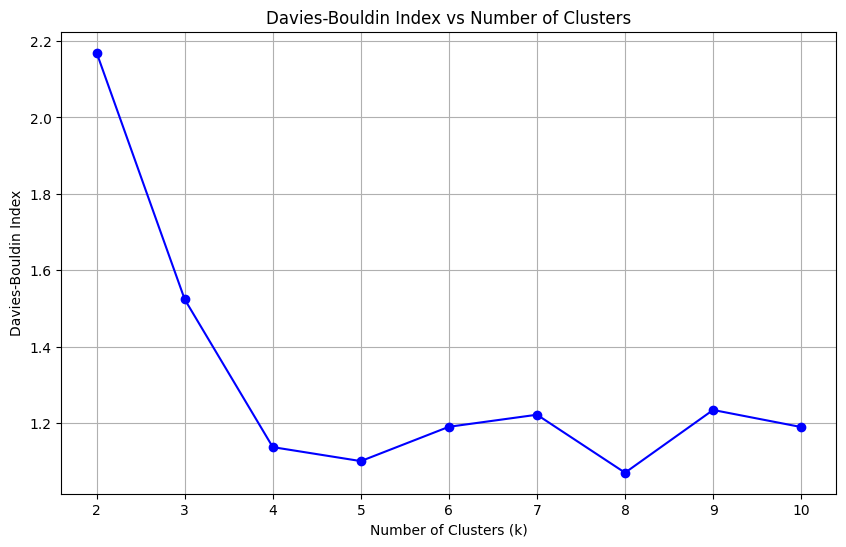

Optimal number of clusters: 8


In [15]:
db_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)
    db_score = davies_bouldin_score(scaled_features, clusters)
    db_scores.append(db_score)

plt.figure(figsize=(10, 6))
plt.plot(k_range, db_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index vs Number of Clusters')
plt.grid(True)
plt.show()

optimal_k = k_range[np.argmin(db_scores)]
print(f'Optimal number of clusters: {optimal_k}')

In [16]:
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = final_kmeans.fit_predict(scaled_features)

clustered_customers = features_df.copy()
clustered_customers['Cluster'] = cluster_labels

cluster_profiles = clustered_customers.groupby('Cluster').mean()
print("\nCluster Profiles:")
print(cluster_profiles)


Cluster Profiles:
             Tenure  region_Asia  region_Europe  region_North America  \
Cluster                                                                 
0        561.000000          0.0            0.1                   0.9   
1        482.515152          0.0            0.0                   0.0   
2        415.636364          0.0            0.0                   1.0   
3        548.615385          1.0            0.0                   0.0   
4        323.800000          0.3            0.2                   0.4   
5        546.382979          0.0            1.0                   0.0   
6        750.560000          0.0            0.0                   0.0   
7        520.875000          1.0            0.0                   0.0   

         region_South America     Recency  Frequency     Monetary  
Cluster                                                            
0                         0.0   27.800000   9.100000  2579.650000  
1                         1.0   73.151515   4.

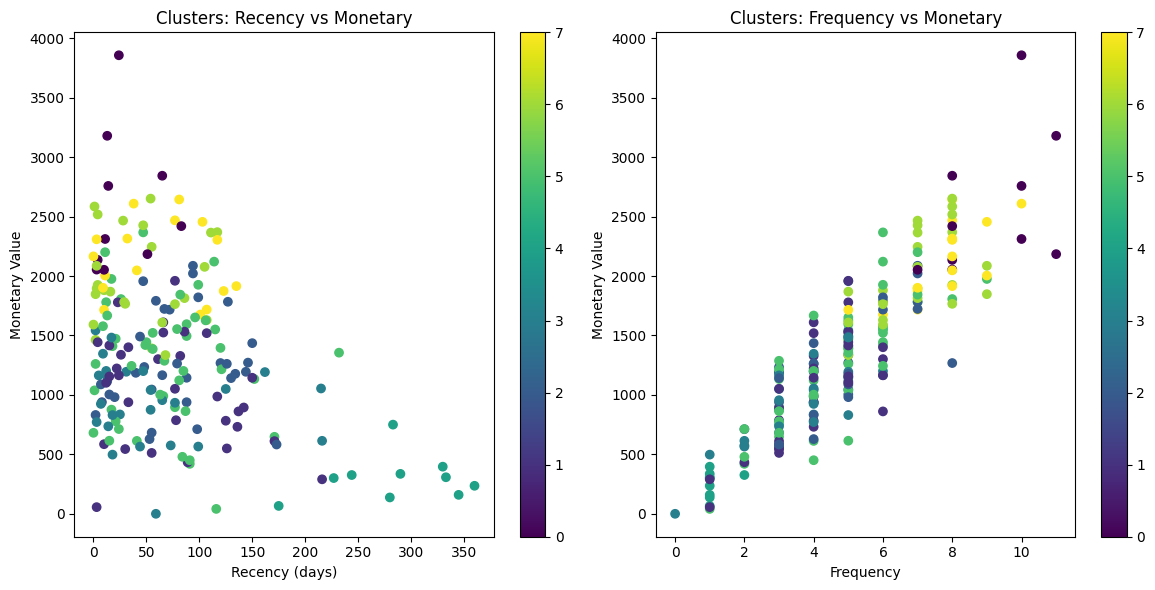

In [17]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
scatter = plt.scatter(clustered_customers['Recency'], 
                     clustered_customers['Monetary'],
                     c=clustered_customers['Cluster'],
                     cmap='viridis')
plt.xlabel('Recency (days)')
plt.ylabel('Monetary Value')
plt.title('Clusters: Recency vs Monetary')
plt.colorbar(scatter)

plt.subplot(1, 2, 2)
scatter = plt.scatter(clustered_customers['Frequency'], 
                     clustered_customers['Monetary'],
                     c=clustered_customers['Cluster'],
                     cmap='viridis')
plt.xlabel('Frequency')
plt.ylabel('Monetary Value')
plt.title('Clusters: Frequency vs Monetary')
plt.colorbar(scatter)

plt.tight_layout()
plt.show()

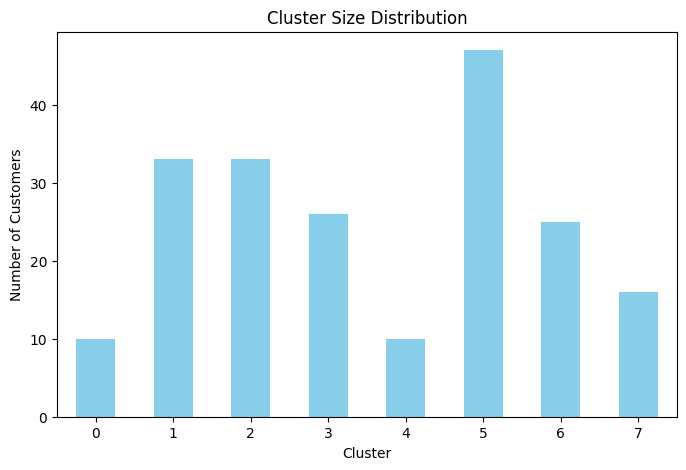

In [18]:
plt.figure(figsize=(8, 5))
clustered_customers['Cluster'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Cluster Size Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.show()


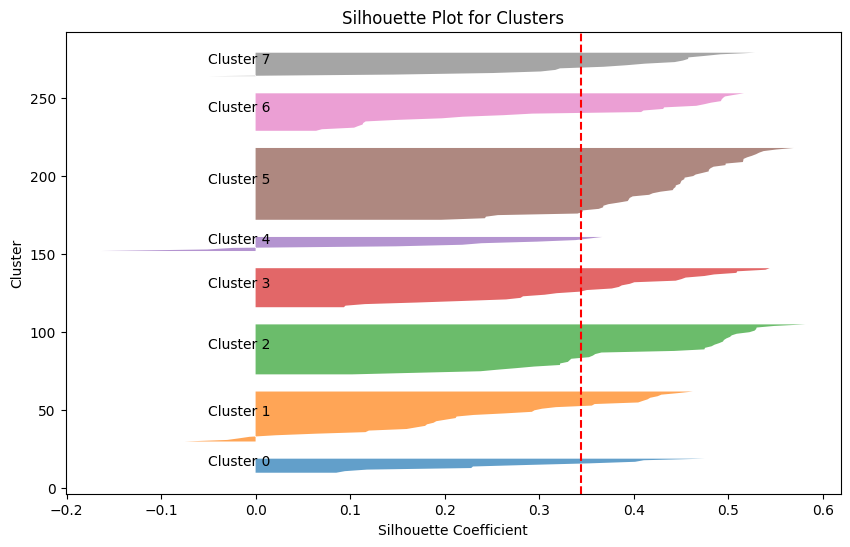

In [19]:
from sklearn.metrics import silhouette_samples, silhouette_score

silhouette_vals = silhouette_samples(scaled_features, cluster_labels)
silhouette_avg = silhouette_score(scaled_features, cluster_labels)

plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(optimal_k):
    ith_cluster_silhouette_values = silhouette_vals[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}')
    y_lower = y_upper + 10

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.title("Silhouette Plot for Clusters")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Cluster")
plt.show()
